In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

### Load data

In [2]:
filename = 'data_5kpa_cleaned_01052022.csv'
df = pd.read_csv(filename)
df.drop(['Unnamed: 0', 'WIDTH_sub', 'HEIGHT_sub', 'mem_layer'], axis=1, inplace=True)
df_var = df[['WIDTH_mem', 'THICKNESS_mem', 'WIDTH_device', 'HEIGHT_chamber', 'HEIGHT_device', 'Stalk_angle']]
df_perf = df[['strength']]

### Variable(s) to drop

In [3]:
var_drop = ['WIDTH_mem', 'THICKNESS_mem', 'HEIGHT_chamber', 'HEIGHT_device', 'Stalk_angle']
df_var = df_var.drop(var_drop, axis=1)

In [4]:
train_X, test_X, train_y, test_y = train_test_split(df_var.values, df_perf.values, 
                                                    test_size=0.2, random_state=33)
X_train = torch.FloatTensor(train_X)
X_test = torch.FloatTensor(test_X)
y_train = torch.FloatTensor(train_y)
y_test = torch.FloatTensor(test_y)

In [5]:
class Model(nn.Module):
    def __init__(self, in_features=1, h1=8, h2=9, out_features=1):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [6]:
torch.manual_seed(11)
model = Model()

In [7]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [8]:
epochs = 1000
losses = []

for i in range(epochs):
    i += 1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    if i%100 == 0:
        print(f'epoch: {i:4}  loss: {loss.item():6.3f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch:  100  loss: 15.144
epoch:  200  loss: 14.421
epoch:  300  loss: 13.467
epoch:  400  loss: 12.284
epoch:  500  loss: 10.829
epoch:  600  loss:  9.025
epoch:  700  loss:  6.871
epoch:  800  loss:  4.775
epoch:  900  loss:  3.564
epoch: 1000  loss:  3.262


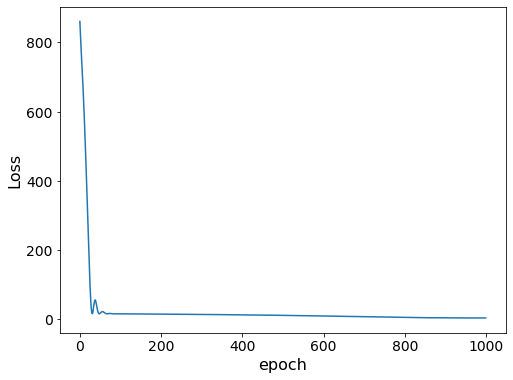

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(range(epochs), losses)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('epoch', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [10]:
with torch.no_grad():
    y_val = model(X_test)
    loss = criterion(y_val, y_test)
print(f'{loss:.8f}')

4.13816118


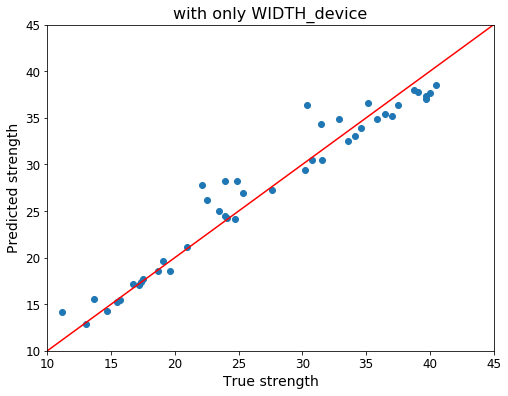

In [11]:
plt.figure(figsize=(8,6))
plt.title('with only WIDTH_device', fontsize=16)
plt.plot([10, 45], [10, 45], c='red')
plt.scatter(y_test[:,0], y_val[:,0])
plt.xlim((10, 45))
plt.ylim((10, 45))
plt.xlabel('True strength', fontsize=14)
plt.ylabel('Predicted strength', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Variable significance

In [12]:
losses_var = {'all_six': 2.71830225, 
              'WIDTH_mem': 3.19635773,
              'THICKNESS_mem': 4.12677002,
              'WIDTH_device': 94.12963104,
              'HEIGHT_chamber': 2.56160831,
              'HEIGHT_device': 2.52148581,
              'Stalk_angle': 2.67338204,
              'WIDTH_mem, THICKNESS_mem': 4.43538666,
              'WIDTH_mem, HEIGHT_chamber': 2.66214728,
              'WIDTH_mem, HEIGHT_device': 2.40139484,
              'WIDTH_mem, Stalk_angle': 2.75034046,
              'THICKNESS_mem, HEIGHT_chamber': 3.45434570,
              'THICKNESS_mem, HEIGHT_device': 3.59999776,
              'THICKNESS_mem, Stalk_angle': 3.61302805,
              'HEIGHT_chamber, HEIGHT_device': 1.93401575,
              'HEIGHT_chamber, Stalk_angle': 2.59922481,
              'HEIGHT_device, Stalk_angle': 3.30265665,
              'all but WIDTH_device': 4.13816118
             }

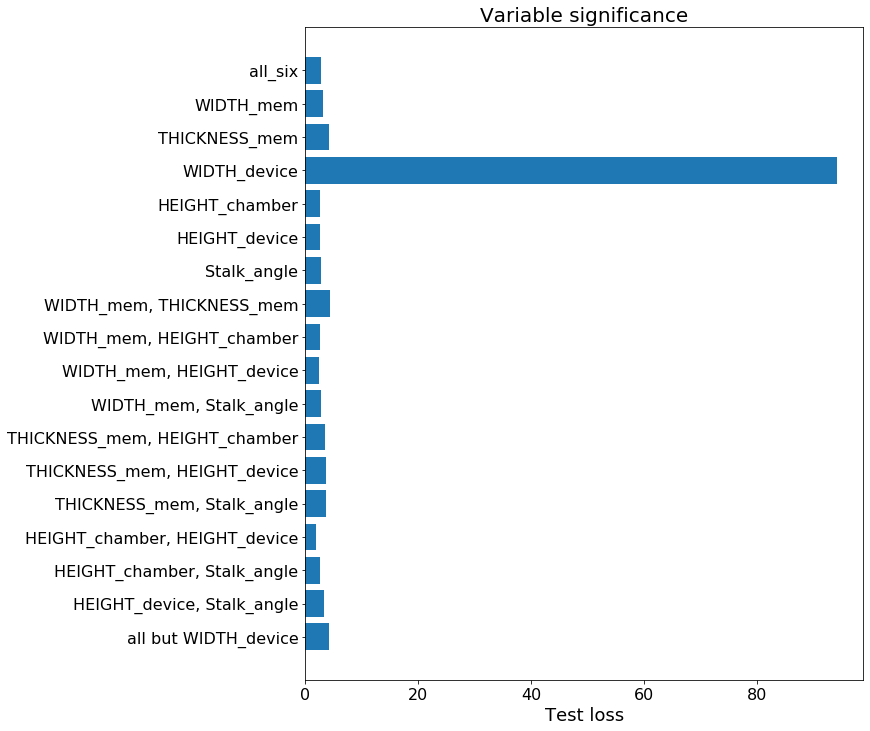

In [13]:
plt.figure(figsize=(10, 12))
plt.barh(list(losses_var.keys())[::-1], list(losses_var.values())[::-1])
plt.title('Variable significance', fontsize=20)
plt.xlabel('Test loss', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()